In [1]:
#importing yfinance api and pandas
import pandas as pd
import yfinance as yf
import datetime as datetime

#fetching data from S&P 500 index using yfinance api
sp500_df = yf.download('^GSPC', start = datetime.datetime(2010, 1, 1), end = datetime.datetime(2019, 12, 31))

[*********************100%%**********************]  1 of 1 completed


In [2]:
#more libraries
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [3]:
#performing some preliminary data checks
sp500_df.dtypes #checking the data types of each feature
sp500_df.isna().sum() #calculate 'NaN' counts for each column

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
#making changes to the dataset
sp500_df = sp500_df.drop(['Open', 'High', 'Low', 'Volume'], axis=1)
sp500_df["Date"] = sp500_df.index
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])
sp500_df.head()

,Close,Adj Close,Date
Date,,,
2010-01-04,1132.989990,1132.989990,2010-01-04
2010-01-05,1136.520020,1136.520020,2010-01-05
2010-01-06,1137.140015,1137.140015,2010-01-06
2010-01-07,1141.689941,1141.689941,2010-01-07
2010-01-08,1144.979980,1144.979980,2010-01-08


In [5]:
#testing stationarity of the data
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    plt.plot(timeseries,color='black',label='Original Data')
    plt.plot(rolmean,color='red',label='Rolling Mean')
    plt.plot(rolstd, color='b', label = 'Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title("Considered data is 'NOT' Stationary")
    plt.xlabel('Year')
    plt.ylabel('Closing Price in USD')
    plt.show(block=False)

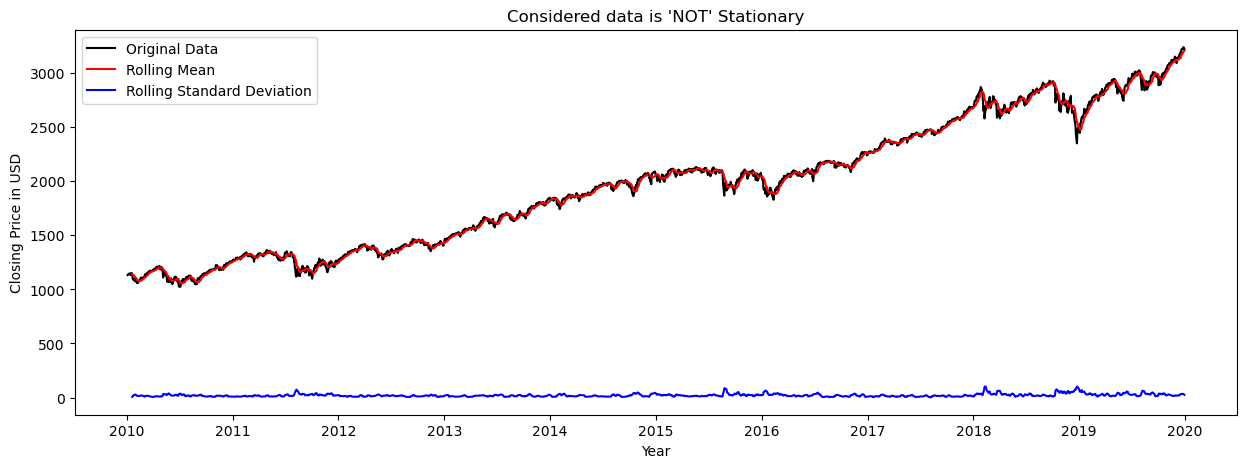

In [6]:
test_stationarity(sp500_df['Adj Close']) 

In [7]:
#performing augmented Dickey-Fuller test
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

result = adfuller(sp500_df['Adj Close'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
#Null hypothesis is true. The values are not stationary

ADF Statistic: 0.406441
p-value: 0.981734
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


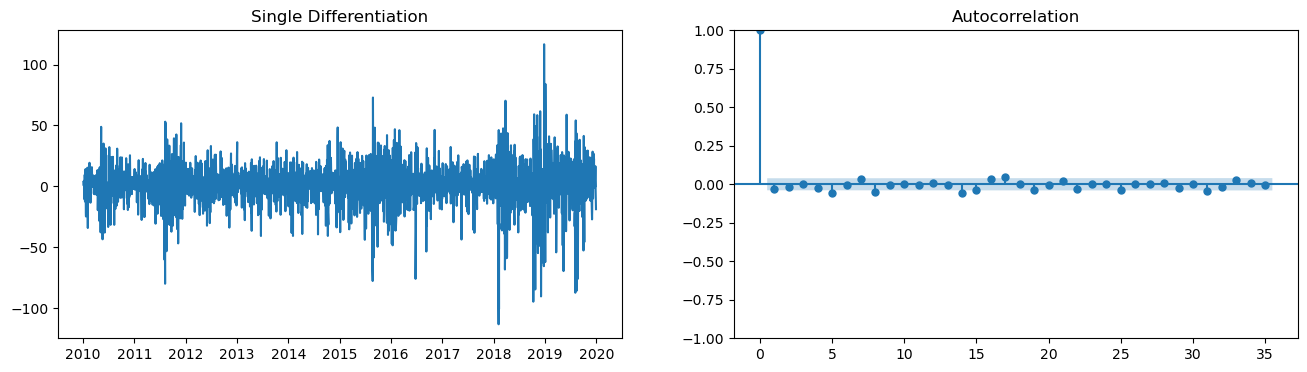

In [8]:
#performing first differencing
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

diff1 = sp500_df['Adj Close'].diff().dropna()
seasonal_diff = sp500_df['Adj Close'] - sp500_df['Adj Close'].shift(12)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff1)
ax1.set_title("Single Differentiation")
plot_acf(diff1, ax=ax2);

In [9]:
result = adfuller(diff1)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#now the data is stationary

ADF Statistic: -12.436965
p-value: 0.000000


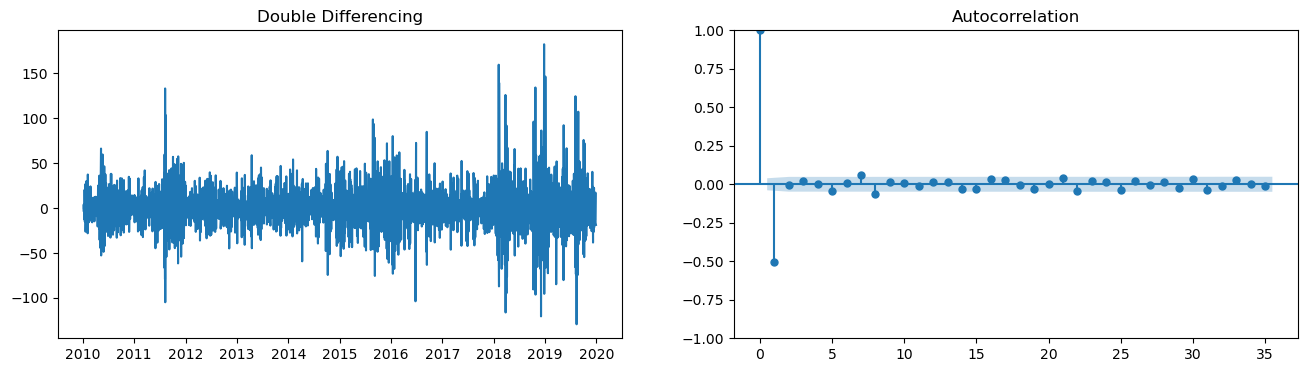

In [11]:
#performing second differencing just out of curiosity
from statsmodels.graphics.tsaplots import plot_acf
diff2 = sp500_df['Adj Close'].diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff2)
ax1.set_title("Double Differencing")
plot_acf(diff2, ax=ax2);

In [13]:
result = adfuller(diff2)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#the model stayed statioanry

ADF Statistic: -16.733727
p-value: 0.000000


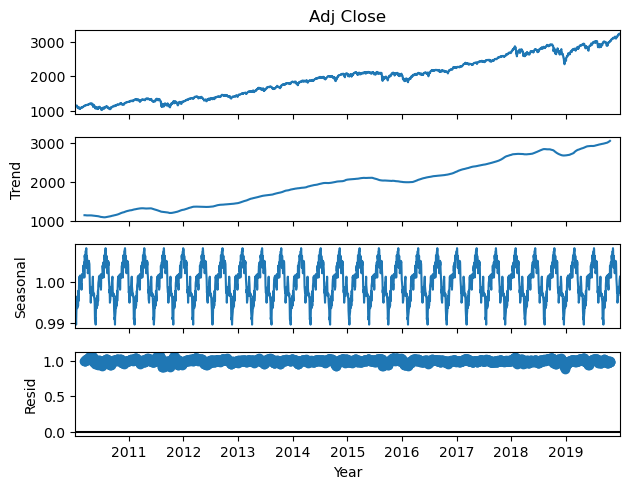

In [14]:
#checking the seasonality of the data
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sp500_df['Adj Close'], model='multiplicative', period=90)
decomposition.plot()
#plt.title('S&P 500 ARIMA Forecast vs Actual')
plt.xlabel('Year')
#plt.ylabel('Closing Price in USD')
plt.show()

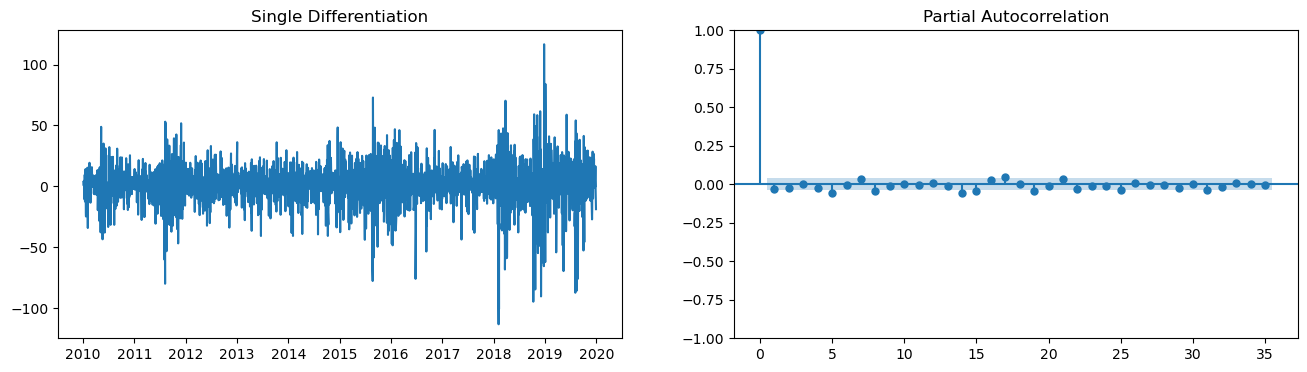

In [15]:
#calculating partial autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf
diff1 = sp500_df['Adj Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff1)
ax1.set_title("Single Differentiation")
ax2.set_ylim(0, 1)
plot_pacf(diff1, ax=ax2);

In [16]:
#seeking number of required differening cycles
from pmdarima.arima.utils import ndiffs
ndiffs(sp500_df['Adj Close'], test="adf")

1

In [17]:
#creating test and train datasets
train_df, test_df = sp500_df.loc[(sp500_df['Date'] <= '2018-12-31')], sp500_df.loc[(sp500_df['Date'] > '2018-12-31')]
#the complete year 2019 is used for testing

In [18]:
#including just the prediction values
train = train_df['Adj Close'].values
test = test_df['Adj Close'].values

In [19]:
#creating functions to remove trend and seasonality in the data
import numpy as np

def difference(dataset, interval=1): #eliminating trend
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1): #reversing function for comparison
    return yhat + history[-interval]

In [20]:
#differencing trend by daily lag
differenced = difference(train)
model=ARIMA(differenced, order=(5,1,7)) #taken from previous plots
model_fit=model.fit()
start=len(train)
end=len(train)+len(test)-1
forecast = model_fit.predict(start=start,end=end)

/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
history = [x for x in train] #to store every additional datapoint after prediction
predicted_results = list()
#storing predictions
for yhat in forecast:
    inverted = inverse_difference(history, yhat)
    history.append(inverted)
    predicted_results.append(inverted)

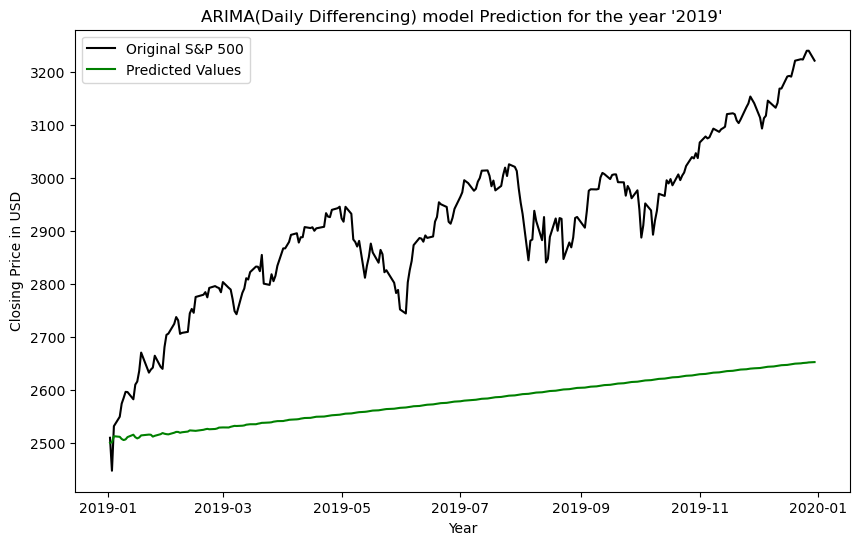

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(test_df.Date, test_df['Adj Close'], color='black', label='Original S&P 500')
plt.plot(test_df.Date, predicted_results, color='green', label='Predicted Values')
plt.title("ARIMA(Daily Differencing) model Prediction for the year '2019'")
plt.xlabel('Year')
plt.ylabel('Closing Price in USD')
plt.legend()
plt.show()

In [23]:
#model validation
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_squared_error(test_df['Adj Close'], predicted_results)
rmse = np.sqrt(mean_squared_error(test_df['Adj Close'], predicted_results))
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 123350.17560966613
Root Mean Squared Error: 351.21243658171636


In [24]:
#differencing using seasonal lag
days_in_year = 365 #seasonality consideration
differenced = difference(train,days_in_year)
model=ARIMA(differenced,order=(5,1,7))
model_fit=model.fit()
start=len(train)
end=len(train)+len(test)-1
forecast = model_fit.predict(start=start,end=end)

/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/nikhilkunapareddy/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
#model prediction
history = [x for x in train]
predicted_results = list() 
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    history.append(inverted)
    predicted_results.append(inverted)

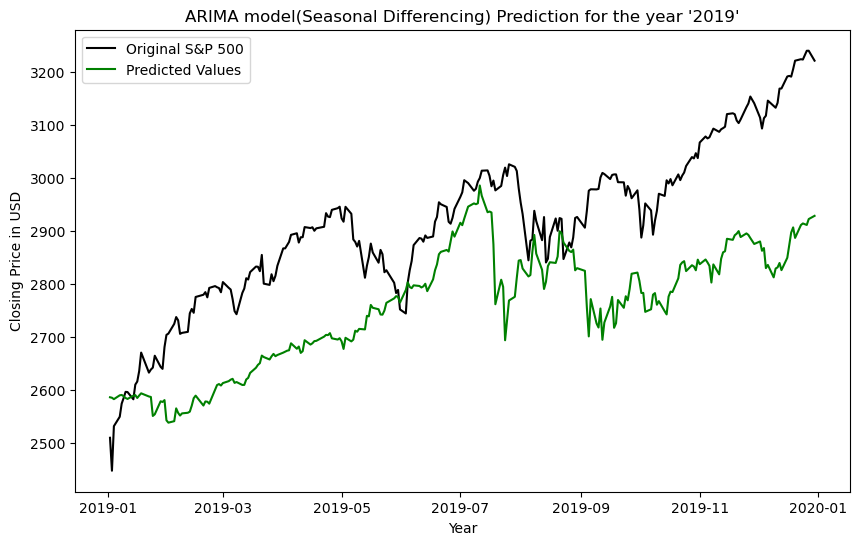

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(test_df.Date, test_df['Adj Close'], color='black', label='Original S&P 500')
plt.plot(test_df.Date, predicted_results, color='green', label='Predicted Values')
plt.title("ARIMA model(Seasonal Differencing) Prediction for the year '2019'")
plt.xlabel('Year')
plt.ylabel('Closing Price in USD')
plt.legend()
plt.show()

In [27]:
#model validation
mae = mean_squared_error(test_df['Adj Close'], predicted_results)
rmse = np.sqrt(mean_squared_error(test_df['Adj Close'], predicted_results))
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 33409.78003413273
Root Mean Squared Error: 182.7834238494638


In [28]:
#performing seasonal and daily differencing
days_in_year=365
differenced_S = difference(train,days_in_year) #first differencing
differenced = difference(differenced_S) #second differencing
model=ARIMA(differenced,order=(5,1,7))
model_fit=model.fit()
start=len(train)
end=len(train)+len(test)-1
forecast = model_fit.predict(start=start,end=end)

In [29]:
history = [x for x in train]
predicted_results = list()
interval=366
for yhat in forecast:
    inverted = inverse_difference(history, yhat, interval)
    history.append(inverted)
    predicted_results.append(inverted)

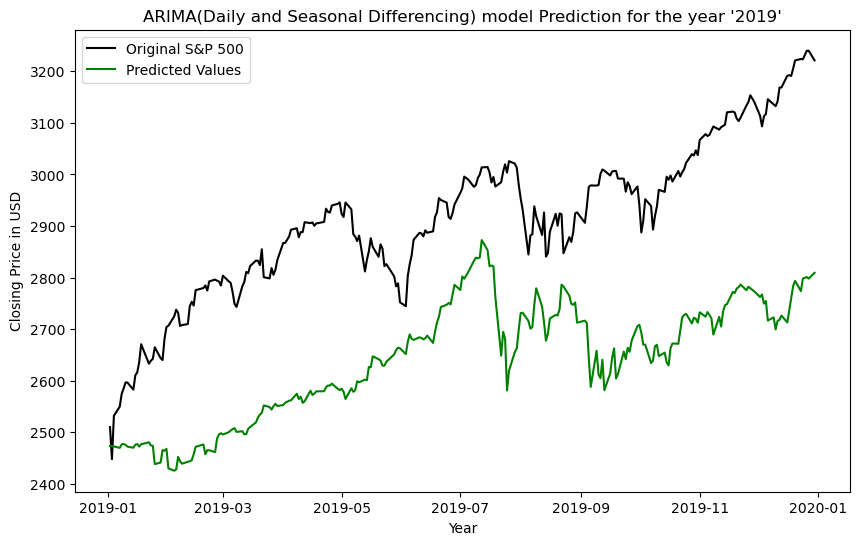

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(test_df.Date, test_df['Adj Close'], color='black', label='Original S&P 500')
plt.plot(test_df.Date, predicted_results, color='green', label='Predicted Values')
plt.title("ARIMA(Daily and Seasonal Differencing) model Prediction for the year '2019'")
plt.xlabel('Year')
plt.ylabel('Closing Price in USD')
plt.legend()
plt.show()

In [31]:
#model validation
mae = mean_squared_error(test_df['Adj Close'], predicted_results)
rmse = np.sqrt(mean_squared_error(test_df['Adj Close'], predicted_results))
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 82643.20075478667
Root Mean Squared Error: 287.4773047647182


In [ ]:
#modeling SARIMA model
import warnings
warnings.filterwarnings('ignore')
history = [x for x in train]
predictions = list()
conf_list = list()
for t in range(len(test)):
    model = sm.tsa.statespace.SARIMAX(history, order = (1, 2, 2), seasonal_order = (1, 1, 1, 3)) #used trial and error and online references to determine orders
    model_fit = model.fit()
    fc = model_fit.forecast()
    predictions.append(fc)
    history.append(test[t])
#cell output is cleared to avoid large number of iteration information. Kindly rerun the cell if interested (it's going to take about 5-10 minutes).

In [ ]:
#model validation
mae = mean_squared_error(test_df['Adj Close'], predictions)
rmse = np.sqrt(mean_squared_error(test_df['Adj Close'], predictions))
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)

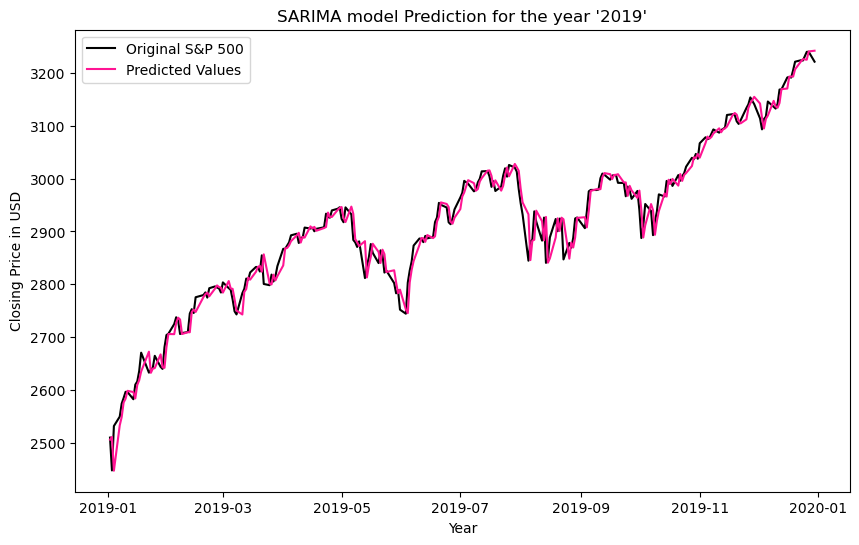

In [236]:
#plotting the SARIMAX model prediction
plt.figure(figsize=(10, 6))
plt.plot(test_df.Date, test_df['Adj Close'], color='black', label='Original S&P 500')
plt.plot(test_df.Date, predictions, color='deeppink', label='Predicted Values')
plt.title("SARIMA model Prediction for the year '2019'")
plt.xlabel('Year')
plt.ylabel('Closing Price in USD')
plt.legend()
plt.show()